<a href="https://colab.research.google.com/github/macgyver121/DADS7202_hw2/blob/main/hw2_v9_17_10_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-08f068bc-1e3e-7125-5a52-dfb33521265c)


In [2]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


## **** Mount + Import library ****

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import tensorflow_hub as hub

from tensorflow.keras import layers
from tensorflow.keras import activations

## **** Import + Prepare Data ****

In [6]:
data_directory = pathlib.Path('/content/drive/MyDrive/hw2_DADS7202_photo_4class')
class_names = [item.name for item in data_directory.glob('*')][0:]
class_names.sort()
print(class_names)

['class1', 'class2', 'class3', 'class4']


In [7]:
class1_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class1'
class2_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class2'
class3_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class3'
class4_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class4'
data_dir = '/content/drive/MyDrive/hw2_DADS7202_photo_4class'

In [ ]:
class1_images = len(os.listdir(class1_dir))
class2_images = len(os.listdir(class2_dir))
class3_images = len(os.listdir(class3_dir))
class4_images = len(os.listdir(class4_dir))

print(f'Number of class1 images: {class1_images}')
print(f'Number of class2 images: {class2_images}')
print(f'Number of class3 images: {class3_images}')
print(f'Number of class4 images: {class4_images}')

Number of class1 images: 211
Number of class2 images: 267
Number of class3 images: 200
Number of class4 images: 220


In [ ]:
np.random.seed(1234)
tf.random.set_seed(5678)

# Defining data generator 
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.3)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = 700,
                                          subset = 'training',
                                          class_mode = 'binary')
test_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 300,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 629 images belonging to 4 classes.
Found 269 images belonging to 4 classes.


In [ ]:
x_train, y_train = train_data.next()
len(x_train), len(y_train), x_train[0].shape

(629, 629, (224, 224, 3))

In [ ]:
x_test, y_test = test_data.next()
len(x_test), len(y_test), x_test[0].shape

(269, 269, (224, 224, 3))

## EDA

In [ ]:
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(629, 224, 224, 3) , min=0.0 , max=1.0
x_test: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(269, 224, 224, 3) , min=0.0 , max=1.0


In [ ]:
df_train = pd.DataFrame(y_train, columns = ['class'])
df_test = pd.DataFrame(y_test, columns = ['class'])

In [ ]:
df_train_count = pd.DataFrame(df_train.groupby(['class'])['class'].count())
df_train_count

,class
class,
0.0,148
1.0,187
2.0,140
3.0,154


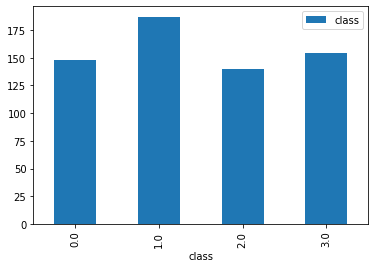

In [ ]:
df_train_count.plot.bar()

In [ ]:
df_test_count = pd.DataFrame(df_test.groupby(['class'])['class'].count())
df_test_count

,class
class,
0.0,63
1.0,80
2.0,60
3.0,66


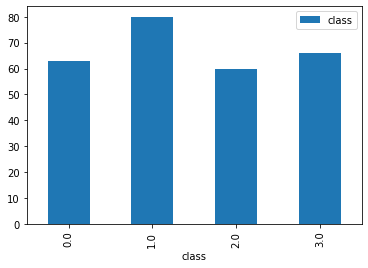

In [ ]:
df_test_count.plot.bar()

In [ ]:
for i in range(10) :
    print(y_train[i])

2.0
2.0
1.0
3.0
3.0
2.0
1.0
3.0
1.0
1.0


Each class size

In [ ]:
from PIL import Image

directories = {'Class_0': '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class1/',
'Class_1': '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class2/',
'Class_2': '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class3/',
'Class_3': '/content/drive/MyDrive/hw2_DADS7202_photo_4class/class4/'}

def get_dims(file):
  im = Image.open(file)
  arr = np.array(im)
  h,w,d = arr.shape
  return h,w

In [ ]:
import dask.bag as bag
from dask.diagnostics import ProgressBar

for n,d in directories.items():
  filepath = d
  filelist = [filepath + f for f in os.listdir(filepath)]
  dims = bag.from_sequence(filelist).map(get_dims)

print(dims[0:10])

with ProgressBar():
  dims = dims.compute()
  dim_df = pd.DataFrame(dims, columns=['height', 'width'])
  sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
  sizes.plot.scatter(x='width', y='height');
  plt.title('Image Sizes (pixels) | {}'.format(n))

TypeError: ignored

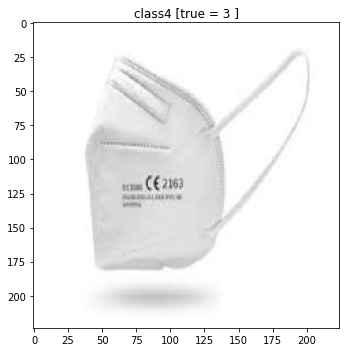

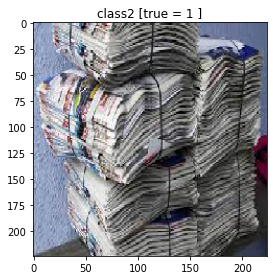

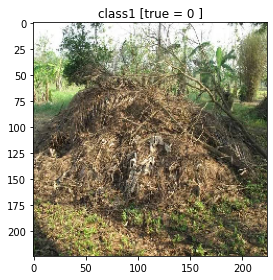

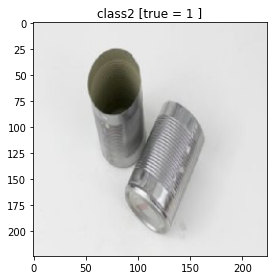

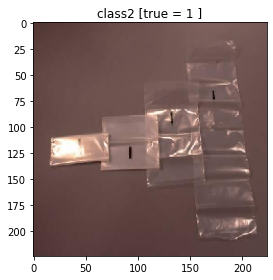

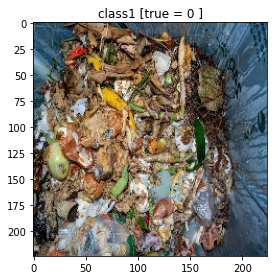

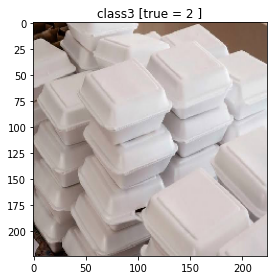

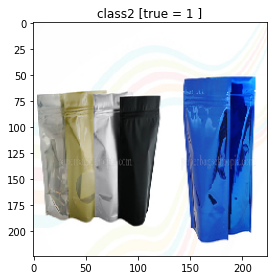

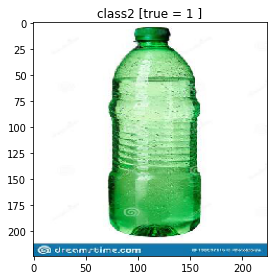

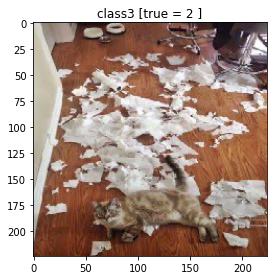

In [ ]:
# Visualize the first five images in x_train
plt.figure(figsize=(10,5))
for i in range(10,20):
    plt.title( f"{class_names[ int(y_train[i]) ]} [true = {int(y_train[i])} ]") 
    plt.imshow( x_train[i] )  
    plt.tight_layout()       
    plt.show()

# VGG-16

## Create the base model from the pre-trained convnets

In [9]:
# Load the ImageNet VGG-16 model, including both the feature extractor part and the classifier part
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=True)

In [10]:
# delete last layer
from keras.models import Model
vgg_extractor= Model(inputs=vgg_extractor.input, outputs=vgg_extractor.layers[-2].output)

## Feature Extractor

### Freeze the convolutional base

In [14]:
vgg_extractor.trainable = False

for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_2 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = False
Layer 18: name = block5_pool , trainable = False
Layer 19: name = flatten , trainable = False
Layer 20: name = fc1 , tr

### Add a classification head

In [15]:
x = vgg_extractor.output

# Add our custom layer(s) to the end of the existing model 

new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Plot Model

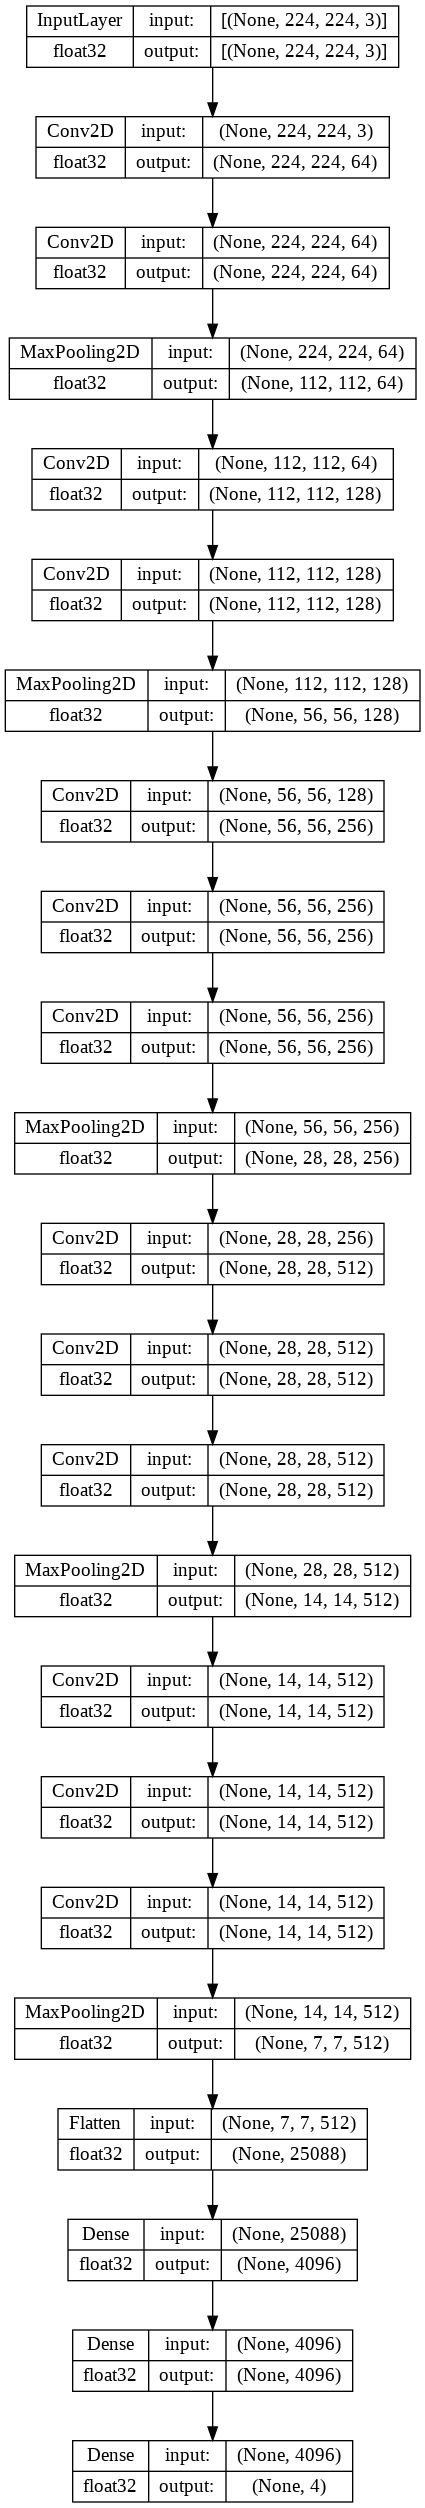

In [16]:
tf.keras.utils.plot_model(model, to_file='vgg_original.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

### Preprocessing input

In [17]:
np.random.seed(1234)
tf.random.set_seed(5678)

# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, rescale = 1/255., validation_split = 0.3)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = 700,
                                          subset = 'training',
                                          class_mode = 'binary')
test_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 300,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 632 images belonging to 4 classes.
Found 269 images belonging to 4 classes.


In [18]:
x_train, y_train = train_data.next()
x_test, y_test = test_data.next()

### Compile the model

In [19]:
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

### Train the model

In [20]:
from datetime import datetime
start_time = datetime.now()

np.random.seed(1234)
tf.random.set_seed(5678)

from keras import callbacks

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 1.1052 - acc: 0.5113
Epoch 1: val_acc improved from -inf to 0.57895, saving model to weights.hdf5
45/45 [==============================] - 17s 168ms/step - loss: 1.1052 - acc: 0.5113 - val_loss: 0.9619 - val_acc: 0.5789
Epoch 2/10
44/45 [============================>.] - ETA: 0s - loss: 0.7589 - acc: 0.6977
Epoch 2: val_acc improved from 0.57895 to 0.72632, saving model to weights.hdf5
45/45 [==============================] - 6s 139ms/step - loss: 0.7560 - acc: 0.6991 - val_loss: 0.6917 - val_acc: 0.7263
Epoch 3/10
44/45 [============================>.] - ETA: 0s - loss: 0.6218 - acc: 0.7523
Epoch 3: val_acc improved from 0.72632 to 0.75263, saving model to weights.hdf5
45/45 [==============================] - 6s 139ms/step - loss: 0.6232 - acc: 0.7511 - val_loss: 0.5893 - val_acc: 0.7526
Epoch 4/10
44/45 [============================>.] - ETA: 0s - loss: 0.6048 - acc: 0.7636
Epoch 4: val_acc did not improve from 0.752

### Learning curves

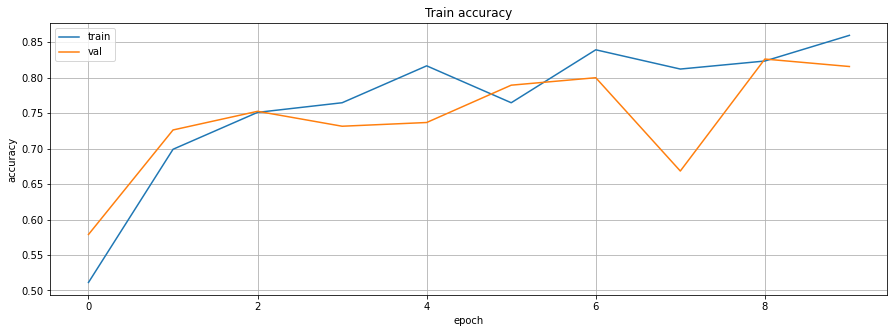

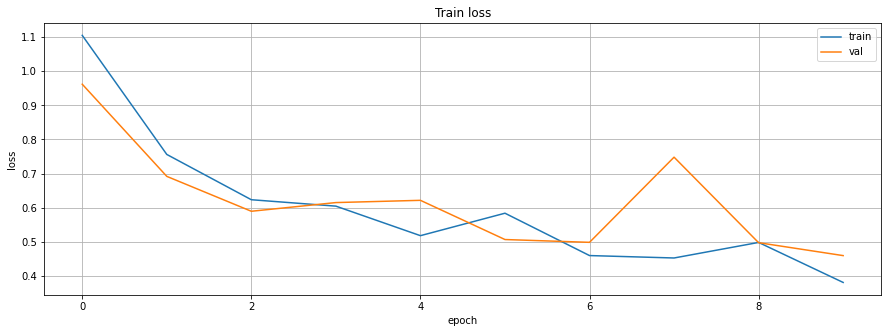

In [21]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

### Evaluate on test set

In [22]:
# Evaluate the trained model on the test set
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

9/9 [==============================] - 6s 320ms/step - loss: 0.8673 - acc: 0.6877
['loss', 'acc']: [0.8672815561294556, 0.6877323389053345]
Duration: 0:00:05.685111


### Evaluate on test set without seed

In [25]:
# create model
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=True)
vgg_extractor= Model(inputs=vgg_extractor.input, outputs=vgg_extractor.layers[-2].output)
vgg_extractor.trainable = False

# add classifier
x = vgg_extractor.output
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)

#train model without seed
model.compile( loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"] )

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)
history = model.fit( x_train , y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

#Evaluate on test set without seed
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
44/45 [============================>.] - ETA: 0s - loss: 1.2438 - acc: 0.4591
Epoch 1: val_acc improved from -inf to 0.61579, saving model to weights.hdf5
45/45 [==============================] - 7s 149ms/step - loss: 1.2396 - acc: 0.4615 - val_loss: 0.8311 - val_acc: 0.6158
Epoch 2/10
44/45 [============================>.] - ETA: 0s - loss: 0.7389 - acc: 0.7045
Epoch 2: val_acc improved from 0.61579 to 0.68947, saving model to weights.hdf5
45/45 [==============================] - 6s 142ms/step - loss: 0.7365 - acc: 0.7059 - val_loss: 0.7319 - val_acc: 0.6895
Epoch 3/10
44/45 [============================>.] - ETA: 0s - loss: 0.6267 - acc: 0.7364
Epoch 3: val_acc improved from 0.68947 to 0.76316, saving model to weights.hdf5
45/45 [==============================] - 6s 141ms/step - loss: 0.6288 - acc: 0.7330 - val_loss: 0.5886 - val_acc: 0.7632
Epoch 4/10
44/45 [============================>.] - ETA: 0s - loss: 0.6177 - acc: 0.7591
Epoch 4: val_acc did not improve from 0.7631

## Fine tuning

### Create feature extractor

In [35]:
img_w,img_h = 224,224
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))
vgg_extractor.trainable = False

### Un-freeze the top layers of the model



In [36]:
vgg_extractor.layers[-2].trainable = True
vgg_extractor.layers[-1].trainable = True

In [37]:
for i,layer in enumerate(vgg_extractor.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_8 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = True
Layer 18: name = block5_pool , trainable = True


### Add a classification head

In [38]:
x = vgg_extractor.output

# Add our custom layer(s) to the end of the existing model 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model 
model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [39]:
for i,layer in enumerate(model.layers):  
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_8 , trainable = False
Layer 1: name = block1_conv1 , trainable = False
Layer 2: name = block1_conv2 , trainable = False
Layer 3: name = block1_pool , trainable = False
Layer 4: name = block2_conv1 , trainable = False
Layer 5: name = block2_conv2 , trainable = False
Layer 6: name = block2_pool , trainable = False
Layer 7: name = block3_conv1 , trainable = False
Layer 8: name = block3_conv2 , trainable = False
Layer 9: name = block3_conv3 , trainable = False
Layer 10: name = block3_pool , trainable = False
Layer 11: name = block4_conv1 , trainable = False
Layer 12: name = block4_conv2 , trainable = False
Layer 13: name = block4_conv3 , trainable = False
Layer 14: name = block4_pool , trainable = False
Layer 15: name = block5_conv1 , trainable = False
Layer 16: name = block5_conv2 , trainable = False
Layer 17: name = block5_conv3 , trainable = True
Layer 18: name = block5_pool , trainable = True
Layer 19: name = flatten_2 , trainable = True
Layer 20: name = dense_9 ,

Model flow

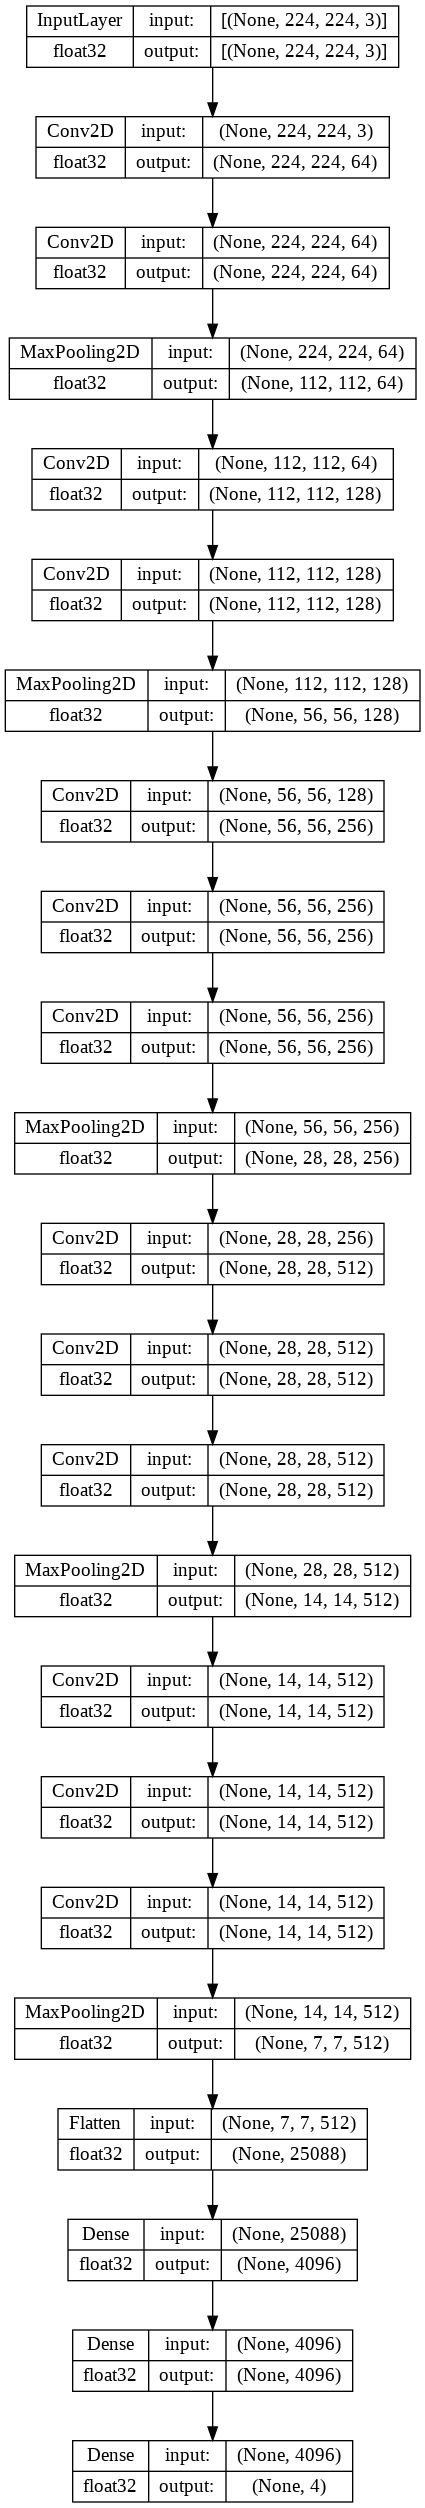

In [40]:
tf.keras.utils.plot_model(model, to_file='vgg_original.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

### Compile the model

In [41]:
alpha = 0.001
model.compile( loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate = alpha) , metrics=["acc"] )

### Train the model

In [42]:
from datetime import datetime
start_time = datetime.now()

np.random.seed(1234)
tf.random.set_seed(5678)

from keras import callbacks

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 3.5572 - acc: 0.5769
Epoch 1: val_acc improved from -inf to 0.64211, saving model to weights.hdf5
45/45 [==============================] - 15s 291ms/step - loss: 3.5572 - acc: 0.5769 - val_loss: 0.6937 - val_acc: 0.6421
Epoch 2/10
44/45 [============================>.] - ETA: 0s - loss: 0.3441 - acc: 0.8727
Epoch 2: val_acc improved from 0.64211 to 0.81053, saving model to weights.hdf5
45/45 [==============================] - 12s 260ms/step - loss: 0.3425 - acc: 0.8733 - val_loss: 0.5940 - val_acc: 0.8105
Epoch 3/10
44/45 [============================>.] - ETA: 0s - loss: 0.0873 - acc: 0.9682
Epoch 3: val_acc improved from 0.81053 to 0.84211, saving model to weights.hdf5
45/45 [==============================] - 12s 268ms/step - loss: 0.0870 - acc: 0.9683 - val_loss: 0.4160 - val_acc: 0.8421
Epoch 4/10
44/45 [============================>.] - ETA: 0s - loss: 0.0182 - acc: 0.9955
Epoch 4: val_acc improved from 0.84211 to

### Learning curves

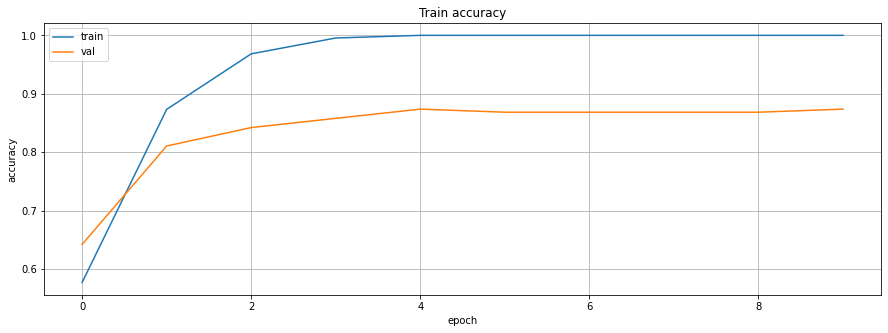

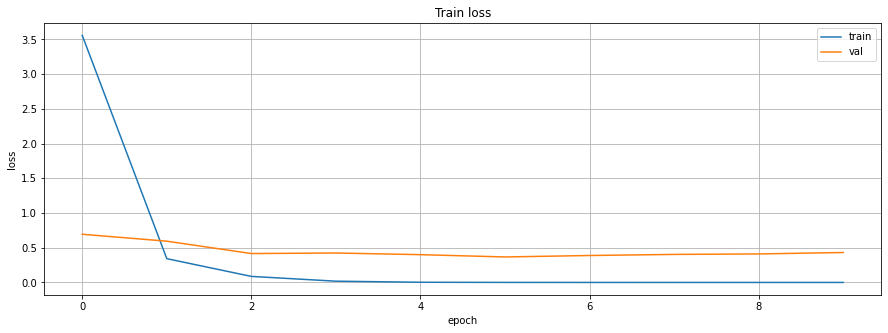

In [43]:
# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

### Evaluate on test set

In [44]:
# Evaluate the trained model on the test set
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

9/9 [==============================] - 2s 148ms/step - loss: 1.5482 - acc: 0.6989
['loss', 'acc']: [1.5482128858566284, 0.6988847851753235]
Duration: 0:00:01.704761


### Evaluate on test set without seed

In [45]:
# create model
img_w,img_h = 224,224 
vgg_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))
vgg_extractor.trainable = False
vgg_extractor.layers[-2].trainable = True
vgg_extractor.layers[-1].trainable = True
x = vgg_extractor.output

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
x = tf.keras.layers.Dense(4096, activation="relu")(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

model = tf.keras.models.Model(inputs=vgg_extractor.inputs, outputs=new_outputs)

#train model without seed
alpha = 0.001
model.compile( loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adamax(learning_rate = alpha) , metrics=["acc"] )

start_time = datetime.now()
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor = 'val_acc', verbose=1, save_best_only=True)

history = model.fit( x_train , y_train, batch_size=10, epochs=10, verbose=1, validation_split=0.3, callbacks=[checkpointer] )
model.load_weights('weights.hdf5')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

#Evaluate on test set without seed
start_time = datetime.now()

results = model.evaluate(x_test, y_test, batch_size=32)
print( f"{model.metrics_names}: {results}" )

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Epoch 1/10
44/45 [============================>.] - ETA: 0s - loss: 4.9485 - acc: 0.5386
Epoch 1: val_acc improved from -inf to 0.62105, saving model to weights.hdf5
45/45 [==============================] - 13s 276ms/step - loss: 4.9267 - acc: 0.5407 - val_loss: 0.7310 - val_acc: 0.6211
Epoch 2/10
44/45 [============================>.] - ETA: 0s - loss: 0.4019 - acc: 0.8477
Epoch 2: val_acc improved from 0.62105 to 0.76316, saving model to weights.hdf5
45/45 [==============================] - 12s 263ms/step - loss: 0.4001 - acc: 0.8484 - val_loss: 0.6286 - val_acc: 0.7632
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.0924 - acc: 0.9751
Epoch 3: val_acc improved from 0.76316 to 0.85263, saving model to weights.hdf5
45/45 [==============================] - 13s 290ms/step - loss: 0.0924 - acc: 0.9751 - val_loss: 0.4222 - val_acc: 0.8526
Epoch 4/10
44/45 [============================>.] - ETA: 0s - loss: 0.0330 - acc: 0.9841
Epoch 4: val_acc did not improve from 0.8

## Inference + Prediction

In [46]:
y_pred = model.predict(x_test)
print(y_pred.shape)

9/9 [==============================] - 1s 156ms/step
(269, 4)


In [47]:
lst = []
for i in y_pred :
    lst.append(np.argmax(i))

type(np.array(lst))

numpy.ndarray

In [48]:
y_test[0:10]

array([1., 0., 1., 2., 1., 1., 2., 2., 3., 0.], dtype=float32)

In [49]:
lst[0:10]

[3, 1, 1, 2, 1, 1, 1, 3, 3, 2]

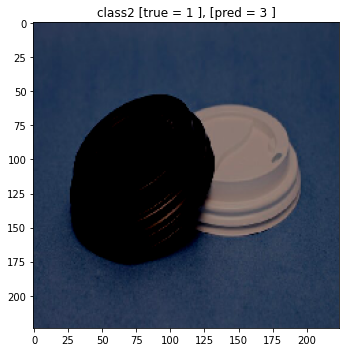

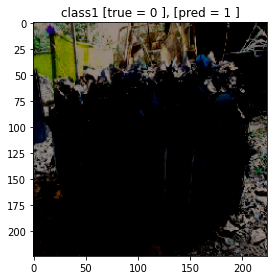

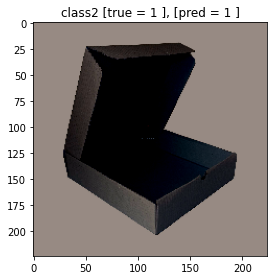

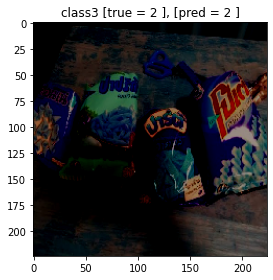

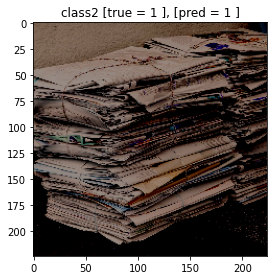

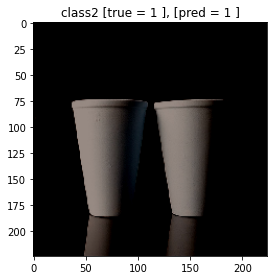

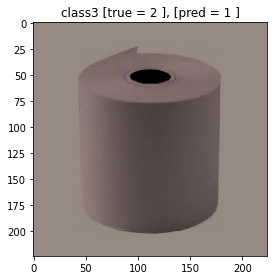

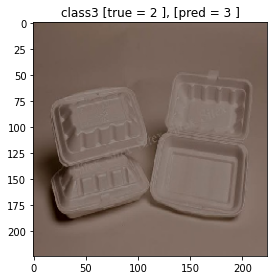

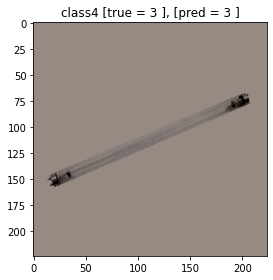

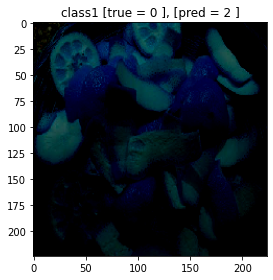

In [50]:
# Visualize the first five images in test
plt.figure(figsize=(10,5))
for i in range(0,10):
    plt.title( f"{class_names[ int(y_test[i]) ]} [true = {int(y_test[i])} ], [pred = {lst[i]} ]") 
    plt.imshow( x_test[i] )  
    plt.tight_layout()       
    plt.show()

## Check error

In [51]:
y_test = y_test.astype(int)
df = pd.DataFrame(list(zip(y_test, lst)), columns = ['y_test', 'y_pred'])

In [52]:
print(df.head())

   y_test  y_pred
0       1       3
1       0       1
2       1       1
3       2       2
4       1       1


In [53]:
index_list = df[df['y_test'] != df['y_pred']].index

In [54]:
index_list

Int64Index([  0,   1,   6,   7,   9,  10,  11,  13,  22,  25,  26,  27,  29,
             33,  36,  38,  40,  44,  45,  46,  52,  53,  54,  56,  60,  62,
             78,  87,  88,  98,  99, 100, 112, 117, 119, 127, 130, 131, 132,
            133, 136, 151, 160, 162, 165, 166, 170, 171, 177, 179, 180, 184,
            187, 192, 194, 195, 199, 205, 207, 210, 211, 215, 221, 224, 226,
            227, 230, 233, 235, 251, 253, 256, 258, 260, 265, 267, 268],
           dtype='int64')

In [55]:
len(index_list)

77

In [56]:
df.iloc[index_list]

,y_test,y_pred
0,1,3
1,0,1
6,2,1
7,2,3
9,0,2
...,...,...
258,2,3
260,1,3
265,3,2
267,1,2


In [ ]:
# Visualize the first five images in test
plt.figure(figsize=(10,5))
for i in index_list:
    plt.title( f"{class_names[ int(y_test[i]) ]} [true = {int(y_test[i])} ], [pred = {lst[i]} ]") 
    plt.imshow( x_test[i] )  
    plt.tight_layout()       
    plt.show()